# Quora
*  Source : https://www.kaggle.com/c/quora-question-pairs
* it contain features are :
*                         ID                  :id of data
*                         qid1,qid2           :data each row has two qestions qids are id's of questions
*                         question1,question2 :these are the questions
* class label  : It indicate question1 and question2 are same or not 
                * same:1
                * notsame:0

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from PIL import Image
import pickle
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Naresh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [5]:
df=pd.read_csv('C:\\Users\\Naresh\\OneDrive\\Desktop\\applied ai\\data\\Qura\\train.csv')
print('Number of data points:',df.shape[0])

Number of data points: 404290


In [6]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
unique,duplicate=np.unique(df['is_duplicate'],return_counts=True)

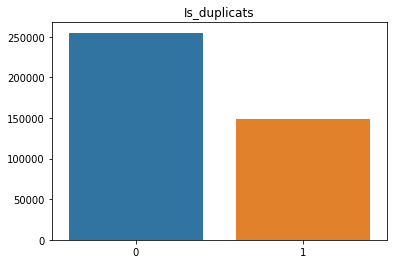

In [9]:
sns.barplot(unique,duplicate)
plt.title('Is_duplicats')
plt.show()

In [10]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs=len(np.unique(qids))
qs_morethen_onetime=np.sum(qids.value_counts()>1)
print('Number of unique questions are:{}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethen_onetime,qs_morethen_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_valss=qids.value_counts()
q_vals=q_valss.values


Number of unique questions are:537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



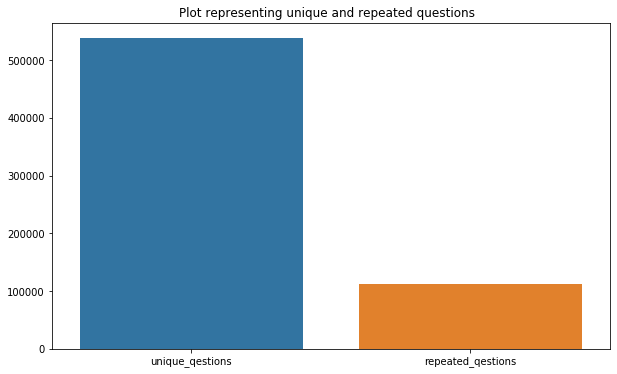

In [11]:
x=['unique_qestions','repeated_qestions']
y=[unique_qs , qs_morethen_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

* Unique qestion are more compared to repeated question
* Our data is imbalnce data

In [12]:
#check duplicate pair of questions
pair_duplicate=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicate).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



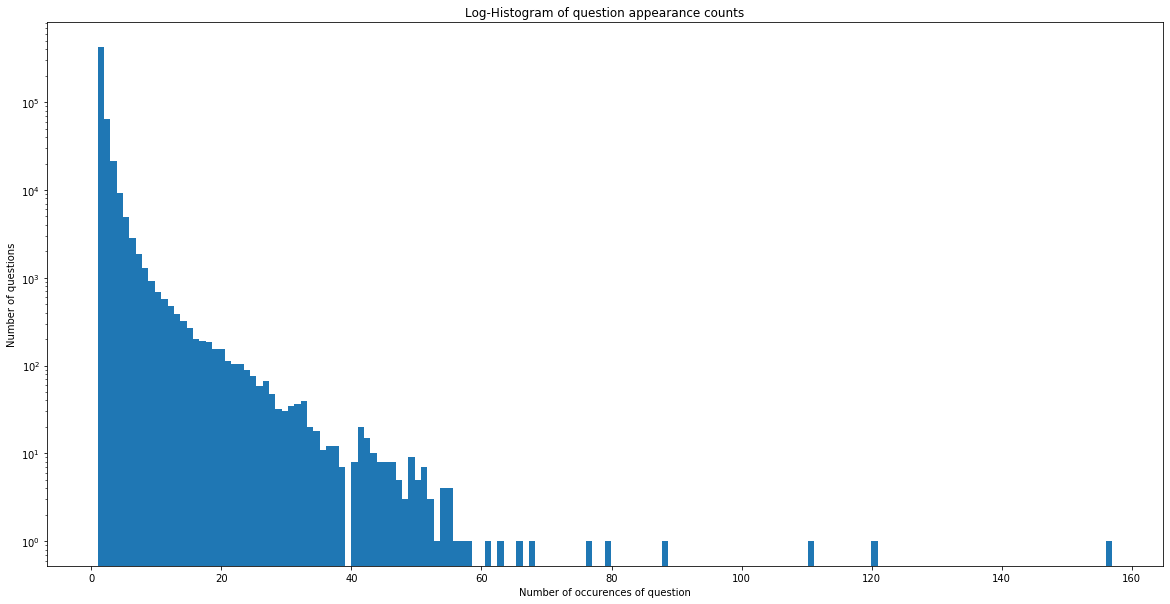

In [13]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

* Distribution of repeation of questions

## Cheaking for missin data

In [14]:
#find null values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [15]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
df=df.fillna('')
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

### Create new features:

* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [17]:
def common_words(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(' ')))
    return len(w1&w2)
def total_words(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(' ')))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(' ')))
    return len(w1)+len(w2)
df['word_Common']=df.apply(common_words,axis=1)
df['word_Total']=df.apply(total_words,axis=1)

In [18]:
df['word_share']=df['word_Common']/df['word_Total']

In [19]:
df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
df['q1len']=df['question1'].str.len()
df['q2len']=df['question2'].str.len()
df['q1_n_words']=df['question1'].apply(lambda row:len(row.split(' ')))
df['q2_n_words']=df['question2'].apply(lambda row: len(row.split(' ')))
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [20]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,word_Common,word_Total,word_share,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,23,0.434783,1,1,66,57,14,12,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,20,0.200000,4,1,51,88,8,13,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,4,24,0.166667,1,1,73,59,14,10,2,0


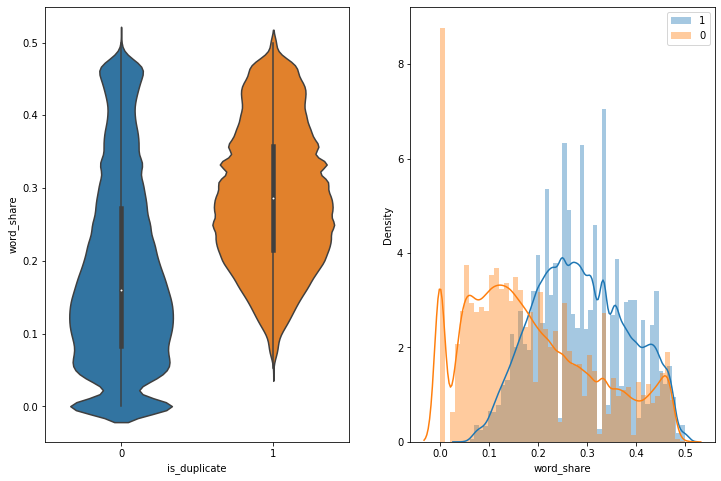

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'],label='1')
sns.distplot(df[df['is_duplicate']==0.0]['word_share'],label='0')
plt.legend()
plt.show()

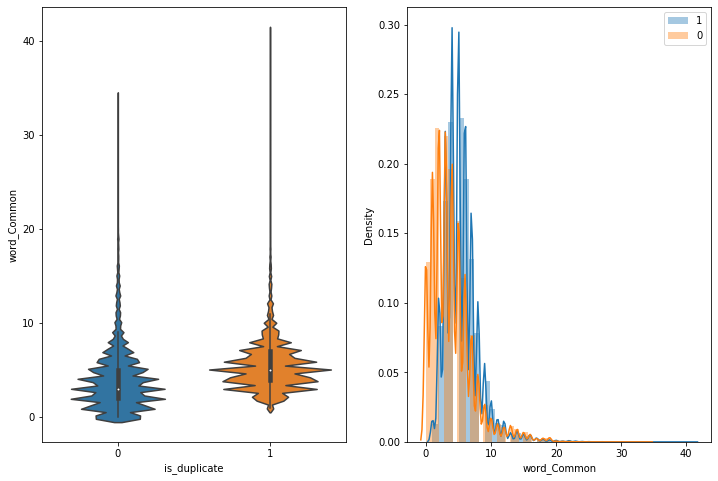

In [22]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_Common'],label='1')
sns.distplot(df[df['is_duplicate']==0.0]['word_Common'],label='0')
plt.legend()
plt.show()

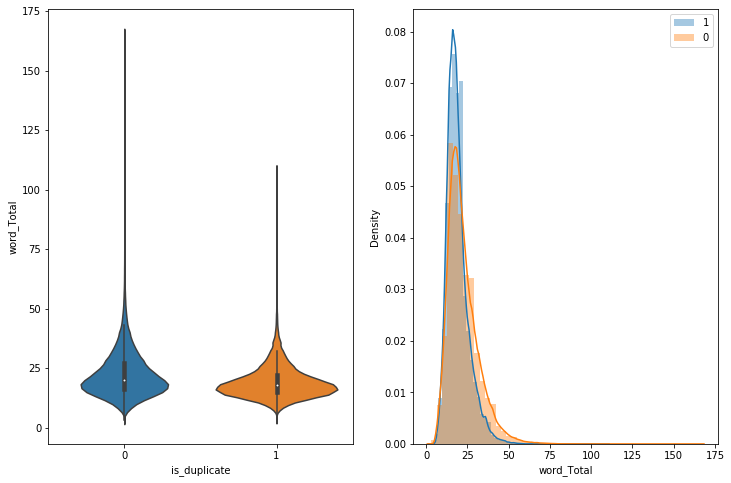

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Total',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_Total'],label='1')
sns.distplot(df[df['is_duplicate']==0.0]['word_Total'],label='0')
plt.legend()
plt.show()

* word_total,and common word count are not much useful

In [24]:

from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Naresh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
#text preprocessing
STOP_WORDS=stopwords.words('english')
def preprocess(x):
    x=str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("can't", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    porter=PorterStemmer()
    pattern=re.compile('\W')
    if type(x)==type(''):
        x=re.sub(pattern,' ',x)
    if type(x)==type(''):
        x=porter.stem(x)
        exam=BeautifulSoup(x)
        x=exam.get_text()
    return x

### Adding some more features

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
def get_token_features(q1,q2):
    SAFE_DIV = 0.0001 
    token_features=[0.0]*10
    q1_token=q1.split()
    q2_token=q2.split()
    if len(q1_token)==0 or len(q2_token)==0:
        return token_features
    q1_words=set([word for word in q1_token if word not in STOP_WORDS])
    q2_words=set([word for word in q2_token if word not in STOP_WORDS])
    q1_stops = set([word for word in q1_token if word in STOP_WORDS])
    q2_stops = set([word for word in q2_token if word in STOP_WORDS])
    common_word_count=len(q1_words & q2_words)
    common_stop_count=len(q1_stops & q2_words)
    common_token_count=len(set(q1_token) & set(q2_token))
    token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)
    # Last word of both question is same or not
    token_features[6] = int(q1_token[-1] == q2_token[-1])
    # First word of both question is same or not
    token_features[7] = int(q1_token[0] == q2_token[0])
    token_features[8] = abs(len(q1_token) - len(q2_token))
    #Average Token Length of both Questions
    token_features[9] = (len(q1_token) + len(q2_token))/2
    return token_features

In [26]:
df['question1']=df['question1'].fillna("").apply(preprocess)
df['question2']=df['question2'].fillna("").apply(preprocess)

In [39]:
 token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

In [46]:
df['cwc_min']=list(map(lambda x: x[0],token_features))
df['cwc_max']=list(map(lambda x: x[1],token_features))
df["csc_min"]= list(map(lambda x: x[2], token_features))
df["csc_max"]= list(map(lambda x: x[3], token_features))
df["ctc_min"]= list(map(lambda x: x[4], token_features))
df["ctc_max"] = list(map(lambda x: x[5], token_features))
df["last_word_eq"]= list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))
df["abs_len_diff"]= list(map(lambda x: x[8], token_features))
df["mean_len"] = list(map(lambda x: x[9], token_features))
df['token_set_ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)
df['token_sort_ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['question1'],x['question2']),axis=1)
df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

In [52]:
filename = 'featured_data'
pickle.dump(df, open(filename, 'wb'))

In [70]:
file=open('featured_data','rb')
df=pickle.load(file)
file.close()

In [4]:
df_duplicate=df[df['is_duplicate']==1]
df_nonduplicate=df[df['is_duplicate']==0]
p=np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

In [5]:
p=str(p)
p=p.replace(' ',',')
p=p.replace('\'\n','')
n=str(n)
n=n.replace(' ',',')
n=n.replace('\'\n','')

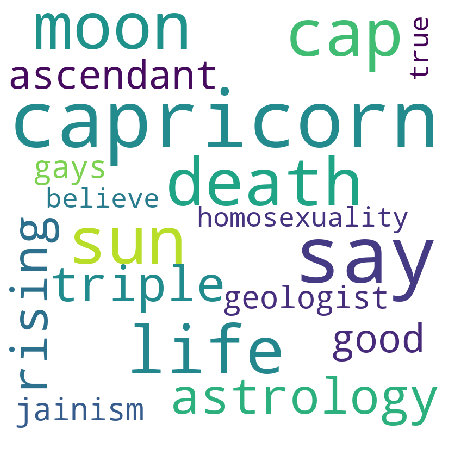

In [6]:
#most frequent words in duplicate text data
from wordcloud import WordCloud,STOPWORDS
stopwords=set(STOPWORDS)
stopwords.discard(('not','no','like'))
wc=WordCloud(width=800,height=800,background_color='white',stopwords=stopwords)
wc.generate(p)
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

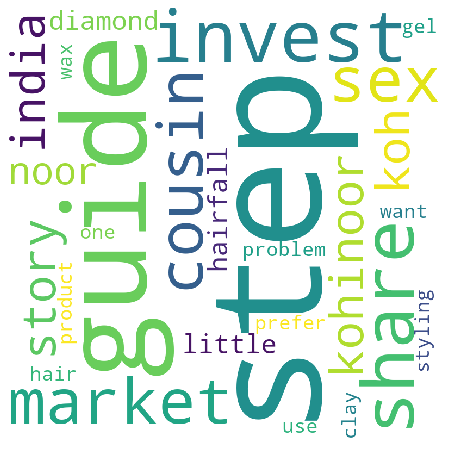

In [7]:
#most frequent words in duplicate text data
wc.generate(n)
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [8]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,word_Common,word_Total,word_share,freq_qid1,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10,23,0.434783,1,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,20,0.200000,4,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


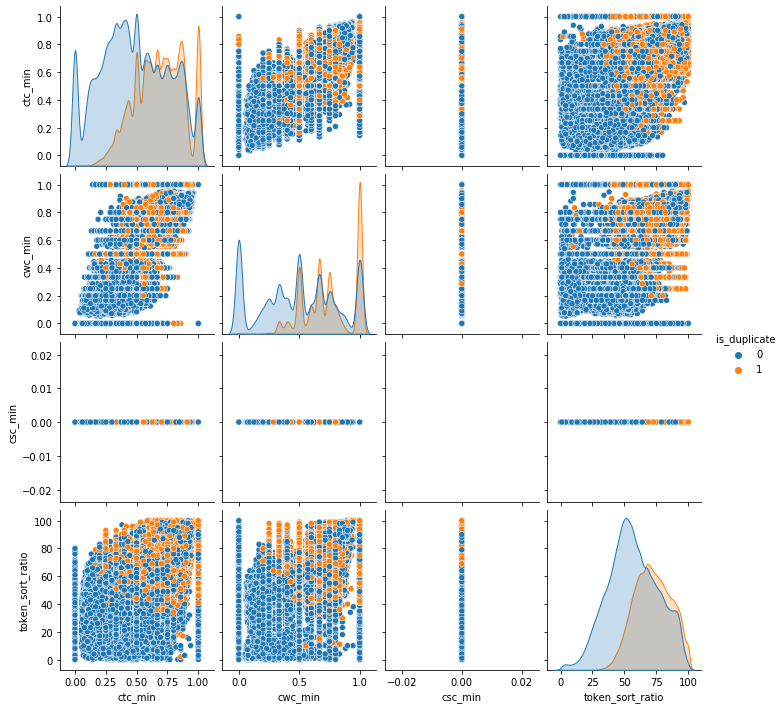

In [8]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

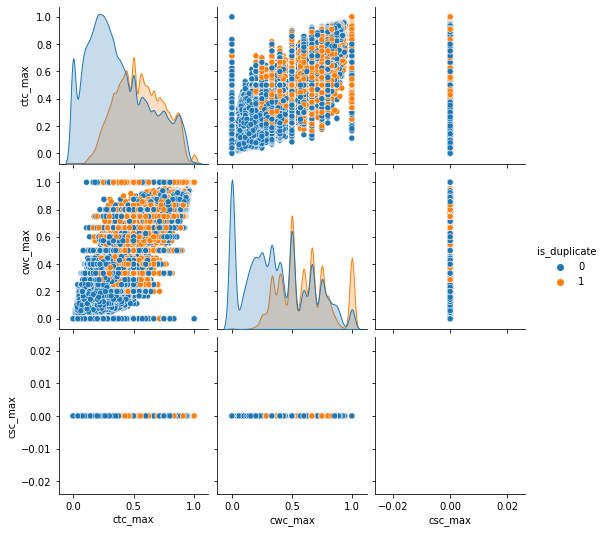

In [16]:
n = df.shape[0]
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max'])
plt.show()

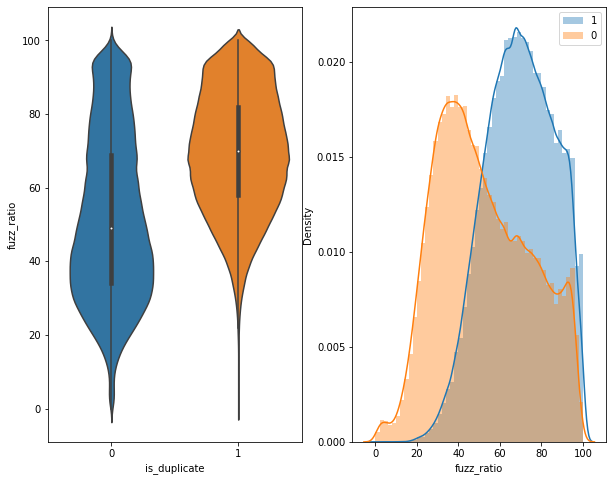

In [13]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1" )
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" )
plt.legend()
plt.show()

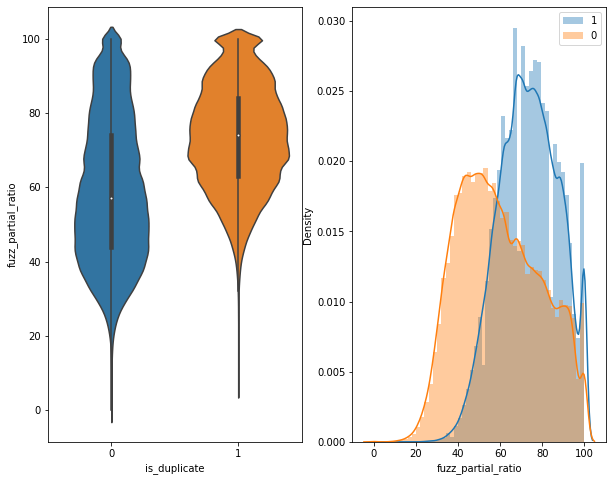

In [15]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1" )
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" )
plt.legend()
plt.show()

* In this some features usefull

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
dfp_subsampled=df[0:5000]
X_m=MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' ]])
X_s=StandardScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' ]])
y=dfp_subsampled['is_duplicate'].values

In [24]:
tsne2d_m=TSNE().fit_transform(X_m)
tsne2d_s=TSNE().fit_transform(X_s)

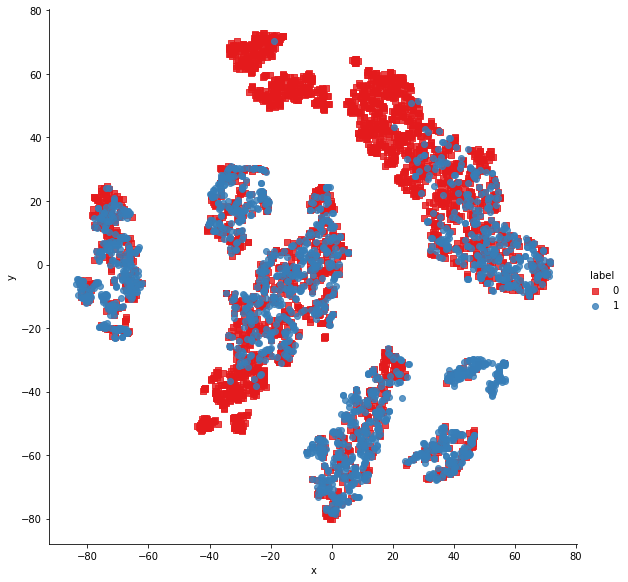

In [27]:
df_m=pd.DataFrame({"x":tsne2d_m[:,0],"y":tsne2d_m[:,1],'label':y})
df_s=pd.DataFrame({"x":tsne2d_s[:,0],"y":tsne2d_s[:,1],'label':y})
sns.lmplot(data=df_m, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.show()

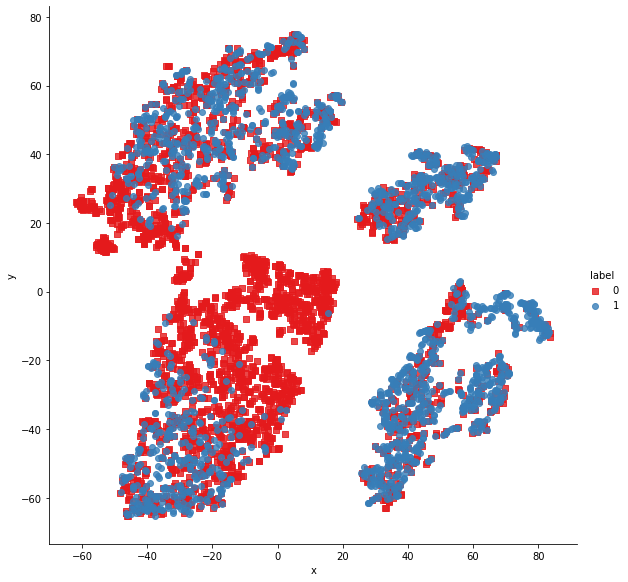

In [28]:
sns.lmplot(data=df_s, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.show()

In [35]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X_m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.094835
[t-SNE] Computed conditional probabilities in 0.229s
[t-SNE] Iteration 50: error = 79.8311691, gradient norm = 0.0291822 (50 iterations in 10.125s)
[t-SNE] Iteration 100: error = 68.6860580, gradient norm = 0.0036341 (50 iterations in 4.832s)
[t-SNE] Iteration 150: error = 67.2798996, gradient norm = 0.0015850 (50 iterations in 4.992s)
[t-SNE] Iteration 200: error = 66.7641144, gradient norm = 0.0012093 (50 iterations in 5.550s)
[t-SNE] Iteration 250: error = 66.4732132, gradient norm = 0.000912

In [36]:
import plotly.express as px
label=dfp_subsampled['is_duplicate'].values
fig=px.scatter_3d(x=tsne3d[:,0],y=tsne3d[:,1],z=tsne3d[:,2],color=label)
plt.show()

In [2]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [3]:
file=open('featured_data','rb')
df=pickle.load(file)
file.close()

In [4]:
y=df['is_duplicate']
X=df.drop('is_duplicate',axis=1)
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [5]:
X_train.head(2)

,id,qid1,qid2,question1,question2,word_Common,word_Total,word_share,freq_qid1,freq_qid2,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
385612,385612,517762,517763,will nitie lose ground to new iims,which is better iim k or nitie,0,14,0.000000,1,1,...,0.142855,0.142855,0.0,0.0,0.0,7.0,53,56,25,28
46341,46341,82912,82913,where can we download old and new hindi songs,which old hindi song has the most number of re...,2,19,0.105263,1,1,...,0.222220,0.199998,0.0,0.0,1.0,9.5,54,50,40,43


In [6]:
Q_train=X_train['question1']+X_train['question2']
Q_test=X_test['question1']+X_test['question2']
tfidf = TfidfVectorizer(min_df=2,ngram_range=(1,2),max_features=5000)
tfidf.fit(Q_train)
q_train_tfidf=tfidf.transform(Q_train.values)
q_test_tfidf=tfidf.transform(Q_test.values)


In [7]:
x_tr=(X_train.drop(['id','qid1','qid2','question1','question2'],axis=1)).values
x_te=(X_test.drop(['id','qid1','qid2','question1','question2'],axis=1)).values

In [8]:
from scipy.sparse import hstack
train_=hstack((q_train_tfidf,x_tr))
test_=hstack((q_test_tfidf,x_te))

In [9]:
train_.shape,test_.shape

((283003, 5025), (121287, 5025))

In [10]:
X_train=train_.tocsr()[0:50000]
y_train=y_train[0:50000]
X_test=test_.tocsr()[0:5000]
y_test=y_test[0:5000]

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (50000, 5025)
Number of data points in test data : (5000, 5025)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.63064 Class 1:  0.36936
---------- Distribution of output variable in train data ----------
Class 0:  0.3672 Class 1:  0.3672


In [34]:
def plot_confusion_matrix(test_y,predict_y):
    akws = {"ha": 'left',"va": 'top'}
    C=confusion_matrix(test_y,predict_y)
    A=(((C.T)/(C.sum(axis=1))).T)#precission matrix
    B=((C/(C.sum(axis=0))).T)#recall
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    print("Confusion matrix\n",C)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    print("Precision matrix\n",A)
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    print("Recall matrix\n",B)
    plt.show()

log loss on test 0.8739119347074041
Confusion matrix
 [[1606 1558]
 [ 932  904]]
Precision matrix
 [[0.50758534 0.49241466]
 [0.50762527 0.49237473]]
Recall matrix
 [[0.63278172 0.36721828]
 [0.63281885 0.36718115]]


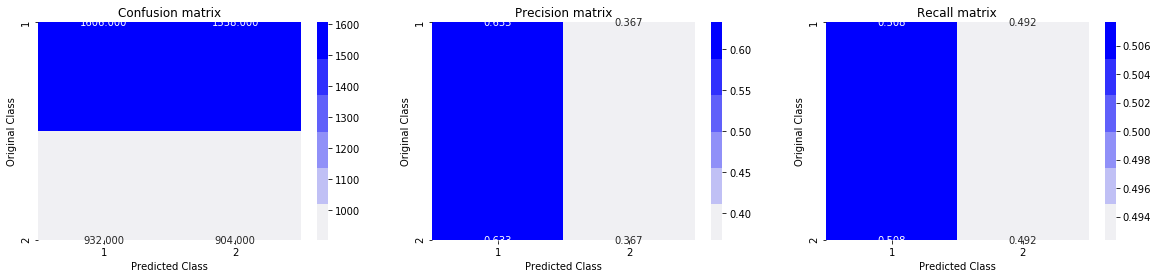

In [35]:
# Random model
predicted_y=np.zeros((test_len,2))
for i in range(test_len):
    random_probs=np.random.rand(1,2)
    predicted_y[i]=((random_probs/sum(sum(random_probs)))[0])
print('log loss on test',log_loss(y_test,predicted_y))
predicted_y=np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [38]:
log_error_array=[]
alpha = [10 ** x for x in range(-5, 2)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.44403211434136935
For values of alpha =  0.0001 The log loss is: 0.42941359839871246
For values of alpha =  0.001 The log loss is: 0.4296450649412067
For values of alpha =  0.01 The log loss is: 0.4521961777592665
For values of alpha =  0.1 The log loss is: 0.4711426555521415
For values of alpha =  1 The log loss is: 0.5027102465504577
For values of alpha =  10 The log loss is: 0.5547140295066885


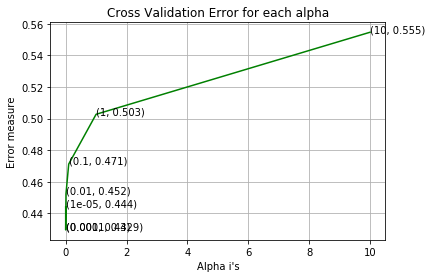

In [39]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.424845699948526
For values of best alpha =  0.0001 The test log loss is: 0.42941359839871246
Total number of data points : 5000
Confusion matrix
 [[2798  366]
 [ 713 1123]]
Precision matrix
 [[0.88432364 0.11567636]
 [0.38834423 0.61165577]]
Recall matrix
 [[0.79692395 0.20307605]
 [0.24580255 0.75419745]]


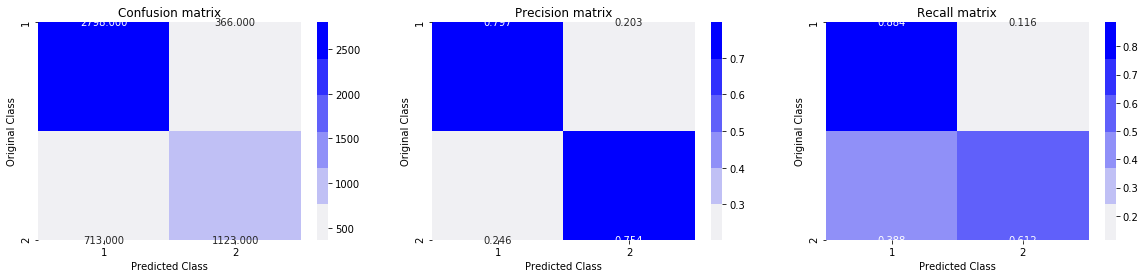

In [40]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [48]:
log_error_array=[]
alpha = [10 ** x for x in range(-5, 2)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.4657407913630925
For values of alpha =  0.0001 The log loss is: 0.4729476038935736
For values of alpha =  0.001 The log loss is: 0.49054457024299425
For values of alpha =  0.01 The log loss is: 0.48245405762802257
For values of alpha =  0.1 The log loss is: 0.4827454059846263
For values of alpha =  1 The log loss is: 0.5899506545260367
For values of alpha =  10 The log loss is: 0.583963864112737


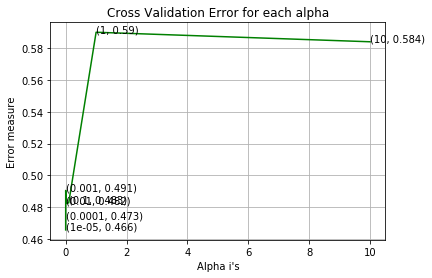

In [49]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.45565038657307966
For values of best alpha =  1e-05 The test log loss is: 0.4657407913630925
Total number of data points : 5000
Confusion matrix
 [[2791  373]
 [ 758 1078]]
Precision matrix
 [[0.88211125 0.11788875]
 [0.41285403 0.58714597]]
Recall matrix
 [[0.78641871 0.21358129]
 [0.25706409 0.74293591]]


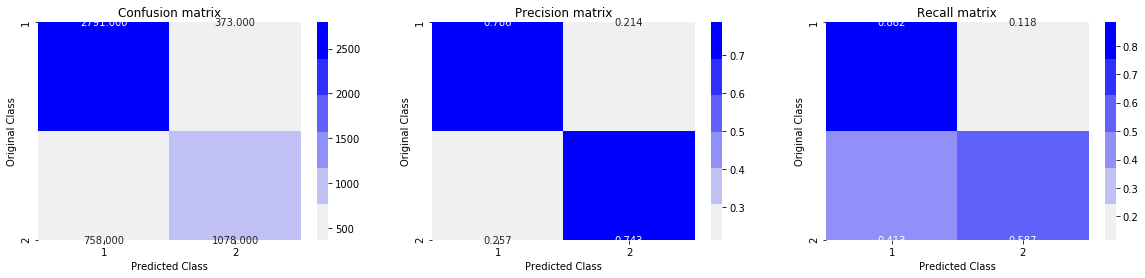

In [50]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [51]:
#from sklearn.naive_bayes import BernoullieNB
from sklearn.naive_bayes import BernoulliNB
log_error_array=[]
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf=BernoulliNB(alpha=i)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.5290916506780899
For values of alpha =  0.0001 The log loss is: 0.5290760961163357
For values of alpha =  0.001 The log loss is: 0.5290310171227638
For values of alpha =  0.01 The log loss is: 0.5289680027906577
For values of alpha =  0.1 The log loss is: 0.5288029712229086
For values of alpha =  1 The log loss is: 0.5278505814861293
For values of alpha =  10 The log loss is: 0.5240024628397332
For values of alpha =  100 The log loss is: 0.6415815243054359


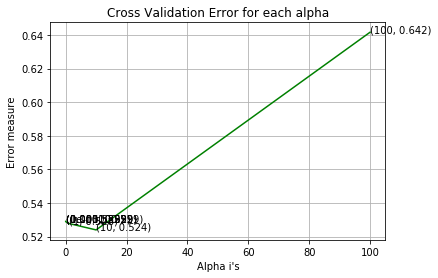

In [52]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  10 The train log loss is: 0.5115323700721469
For values of best alpha =  10 The test log loss is: 0.5283023822028583
Total number of data points : 5000
Confusion matrix
 [[2464  700]
 [ 613 1223]]
Precision matrix
 [[0.77876106 0.22123894]
 [0.333878   0.666122  ]]
Recall matrix
 [[0.80077998 0.19922002]
 [0.36401456 0.63598544]]


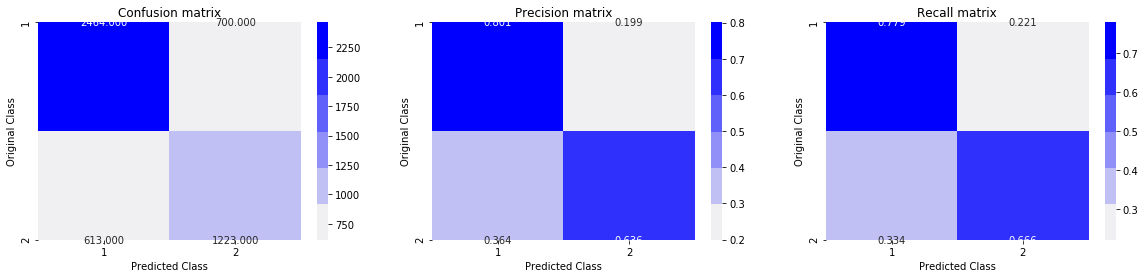

In [53]:
best_alpha = np.argmin(log_error_array)
clf =BernoulliNB(alpha=log_error_array[best_alpha])
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [54]:
from sklearn.naive_bayes import MultinomialNB
log_error_array=[]
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.5730483843792284
For values of alpha =  0.0001 The log loss is: 0.5732584484691353
For values of alpha =  0.001 The log loss is: 0.573407515714167
For values of alpha =  0.01 The log loss is: 0.5736111237419116
For values of alpha =  0.1 The log loss is: 0.5739471583841076
For values of alpha =  1 The log loss is: 0.5749647911402938
For values of alpha =  10 The log loss is: 0.5777260208624598
For values of alpha =  100 The log loss is: 0.5946162226462622


In [56]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
gbdt=XGBClassifier()
parms={'learning_rate':[0.001,0.01,0.1,0.2,0.3],'max_depth':[5,10,50,75,100]}
grid=RandomizedSearchCV(gbdt,parms,scoring='neg_log_loss',cv=3,n_jobs=-1)
grid.fit(X_train,y_train)

Wall time: 20min 48s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_co...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                    

In [63]:
max_depth=[]
learning_rate=[]
test_score=grid.cv_results_['mean_test_score']
for dic in grid.cv_results_['params']:
    max_depth.append(dic['max_depth'])
    learning_rate.append(dic['learning_rate'])

In [65]:
df=pd.DataFrame({'max_depth':max_depth,'learning_rate':learning_rate,'test_score':test_score})
df

,max_depth,learning_rate,test_score
0,50,0.001,-0.645087
1,10,0.100,-0.336873
2,10,0.300,-0.335570
3,100,0.001,-0.645103
4,5,0.010,-0.466434
5,100,0.200,-0.413808
6,50,0.200,-0.407503
7,10,0.010,-0.444812
8,50,0.010,-0.440564
9,5,0.300,-0.338780


In [66]:
grid.best_params_

{'max_depth': 10, 'learning_rate': 0.3}

In [68]:
par=grid.best_params_
clf=XGBClassifier(max_depth=par['max_depth'],learning_rate=par['learning_rate'],n_jobs=-1)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

For values of best parameters =  {'max_depth': 10, 'learning_rate': 0.3} The train log loss is: 0.19602607733741562
For values of best alpha =  {'max_depth': 10, 'learning_rate': 0.3} The test log loss is: 0.5946162226462622
Total number of data points : 5000
Confusion matrix
 [[2431  733]
 [ 782 1054]]
Precision matrix
 [[0.76833123 0.23166877]
 [0.42592593 0.57407407]]
Recall matrix
 [[0.75661376 0.24338624]
 [0.41018467 0.58981533]]


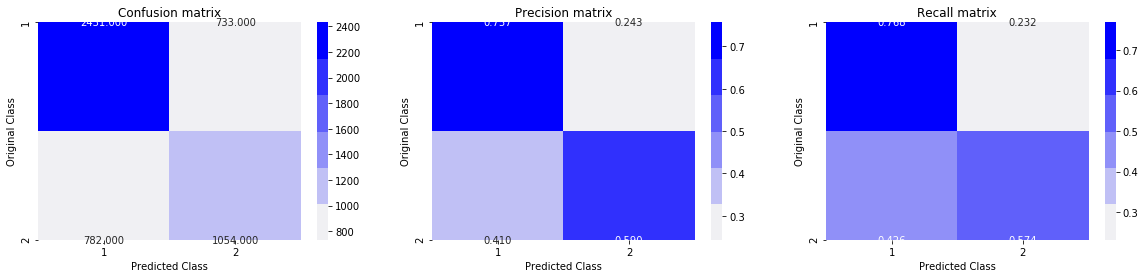

In [69]:
predict_y = clf.predict_proba(X_train)
print('For values of best parameters = ',par, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', par, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)